# Rwanda SAE Project – DHS & Census Harmonization
This notebook contains full Python code for harmonizing DHS and Census datasets.

# Rwanda SAE Project: DHS & Census Harmonization

**Group**: 11  
**Date**: 2025  
**Project**: Small Area Estimation (SAE) with Elevation-Stunting Relationship



## Core Development Team
1.	Gaga Rukorera Didier - Project Lead 

2.	SCOVIA Muhoza - Data Processing Specialist

3.	IRAGUHA Juvenal - Geospatial & Visualization Specialist

4.	SHARANGABO Faustin - Software Development & Deployment



## Project Overview
This notebook demonstrates the integration of multiple data sources to analyze the relationship between **elevation** and **child stunting** in Rwanda, implementing **Small Area Estimation (SAE)** models for poverty mapping and nutritional analysis.

## Data Sources
### 1. DHS Data (Demographic and Health Surveys)
- **Children's Recode** (`RWKR81FL.DTA`) – Stunting measurements & child anthropometrics
- **Individual Recode** (`RWIR81FL.DTA`) – Individual-level socioeconomic characteristics
- **Household Recode** (`RWHR81FL.DTA`) – Household-level indicators & wealth indices

### 2. Census Data (Rwanda Population and Housing Census - PHC5)
- Sector-level population statistics
- Geographic coordinates for elevation data extraction

## Project Objectives
| Objective | Description |
|-----------|-------------|
| **Stunting Prevalence Calculation** | Derive child stunting rates from DHS children's data |
| **Data Harmonization** | Integrate DHS and Census variables for sector-level analysis |
| **Elevation Extraction** | Extract elevation data using geographic coordinates |
| **SAE Model Development** | Implement SAE models incorporating elevation covariates |
| **Relationship Analysis** | Analyze elevation-stunting relationships across Rwanda sectors |

## Key Analytical Steps
1. **Data Processing** – Clean and prepare DHS and Census datasets
2. **Variable Harmonization** – Create common sector-level indicators
3. **Elevation Integration** – Incorporate geographic elevation data
4. **SAE Modeling** – Apply Fay-Herriot and related SAE methods
5. **Validation & Visualization** – Validate models and create spatial maps

---

**Note**: This notebook contains both **real workflow code** and **simulated data** for demonstration purposes. Actual NISR data processing occurs within secure institutional environments.

In [1]:
# Step 1: Setup and Configuration
import pandas as pd
import numpy as np
import requests
import time
import random
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set up paths
base_path = Path("C:/Users/NISR/Desktop/gaga/AIMS/my project SAE")
output_path = base_path / "SEA RWANDA"
dhs_path = base_path / "data_census_DHS/DHS"
census_path = base_path / "data_census_DHS/CENSUS"

# Create output directory
output_path.mkdir(parents=True, exist_ok=True)

print("Setup completed successfully!")
print(f"Output directory: {output_path}")

Setup completed successfully!
Output directory: C:\Users\NISR\Desktop\gaga\AIMS\my project SAE\SEA RWANDA


In [2]:
import pandas as pd
import pyreadstat
from pathlib import Path

# Define paths
spss_file_path = r"C:\Users\NISR\Desktop\USA World_Bank\My new Project\combined.sav"
output_dir = Path(r"C:\Users\NISR\Desktop\USA World_Bank\My new Project")

print("Step 1: Reading file metadata to see available columns...")

# First, let's read just the first few rows to see column names
try:
    # Read only first 10 rows to identify columns
    sample_df, meta = pyreadstat.read_sav(spss_file_path, row_limit=10)
    
    print(f"Successfully read sample data")
    print(f"Shape: {sample_df.shape}")
    print(f"\nAll column names ({len(sample_df.columns)} columns):")
    print("-" * 50)
    
    for i, col in enumerate(sample_df.columns):
        print(f"{i:3}: {col}")
    
    print("\n" + "=" * 50)
    print("Step 2: Looking for your target variables...")
    print("=" * 50)
    
    # Search for columns related to your target variables
    search_terms = {
        'latitude': ['lat', 'latitude'],
        'longitude': ['lon', 'longitude', 'long'],
        'altitude': ['alt', 'altitude', 'elevation'],
        'accuracy': ['acc', 'accuracy', 'prec'],
        'satellites': ['sat', 'satellites', 'gps_sat'],
        'Code_Dist': ['dist', 'district', 'code_dist', 'dist_code'],
        'Code_Sect': ['sect', 'sector', 'code_sect', 'sect_code'],
        'Code_cell': ['cell', 'code_cell', 'cell_code'],
        'Code_vill': ['vill', 'village', 'code_vill', 'vill_code'],
        'EA_Code': ['ea', 'enumeration', 'ea_code', 'code_ea']
    }
    
    found_matches = {}
    for target, keywords in search_terms.items():
        matches = []
        for col in sample_df.columns:
            col_lower = str(col).lower()
            for keyword in keywords:
                if keyword.lower() in col_lower:
                    matches.append(col)
                    break
        
        if matches:
            found_matches[target] = matches
            print(f"✓ {target}: Found {len(matches)} matches → {matches}")
        else:
            print(f"✗ {target}: No matches found")
    
    print("\n" + "=" * 50)
    print("Step 3: Please select the exact column names from above")
    print("=" * 50)
    
    # Display data types for first few columns
    print("\nData types for first 10 columns:")
    for col in sample_df.columns[:10]:
        print(f"{col}: {sample_df[col].dtype}")
    
    # Show sample data for first few columns
    print("\nSample data (first 3 rows):")
    print(sample_df.head(3))
    
    # Save the column list to a text file for reference
    columns_file = output_dir / "available_columns.txt"
    with open(columns_file, 'w', encoding='utf-8') as f:
        f.write("Available columns in combined.sav:\n")
        f.write("=" * 60 + "\n")
        for i, col in enumerate(sample_df.columns):
            f.write(f"{i:3}: {col}\n")
    
    print(f"\nColumn list saved to: {columns_file}")
    
except MemoryError:
    print("MemoryError occurred. Trying a different approach...")
    
    # Try to read metadata only using a different method
    print("\nTrying to read column names without loading data...")
    
    # Use pyreadstat's metadata function (correct syntax)
    try:
        df, meta = pyreadstat.read_sav(spss_file_path, metadataonly=True)
        print(f"Found {len(meta.column_names)} columns")
        print("\nFirst 100 column names:")
        for i, col in enumerate(meta.column_names[:100]):
            print(f"{i:3}: {col}")
    except:
        print("Could not read metadata. The file might be too large or corrupted.")

Step 1: Reading file metadata to see available columns...
Successfully read sample data
Shape: (10, 446)

All column names (446 columns):
--------------------------------------------------
  0: ml01
  1: ml02
  2: ml03
  3: ml04
  4: ml05
  5: ml06
  6: ml09
  7: h01
  8: h02
  9: h03
 10: h04
 11: h05
 12: h06
 13: h06_other
 14: h07
 15: h08
 16: h09
 17: h10
 18: h11
 19: h12
 20: h13
 21: h13_other
 22: h14
 23: h15
 24: h16
 25: h16_other
 26: h17
 27: h17_other
 28: h18
 29: h19
 30: h20
 31: h21_01
 32: h21_02
 33: h21_03
 34: h21_04
 35: h21_05
 36: h21_06
 37: h21_07
 38: h21_08
 39: h21_09
 40: h21_10
 41: h21_11
 42: h21_12
 43: h21_13
 44: h21_14
 45: h21_15
 46: h21_16
 47: h22
 48: h22aidx_01
 49: h22aidx_02
 50: h22aidx_03
 51: h22aidx_04
 52: h22aidx_05
 53: h22aidx_06
 54: h22aidx_07
 55: h22aidx_08
 56: h22aidx_09
 57: h22aidx_10
 58: h22aidx_11
 59: h22aidx_12
 60: h22aidx_13
 61: h22aidx_14
 62: h22aidx_15
 63: h22aidx_16
 64: h22aidx_17
 65: h22aidx_18
 66: h22aidx

In [3]:
import pandas as pd
import pyreadstat
from pathlib import Path
import re

# Define paths
spss_file_path = r"C:\Users\NISR\Desktop\USA World_Bank\My new Project\combined.sav"
output_dir = Path(r"C:\Users\NISR\Desktop\USA World_Bank\My new Project")

print("Reading sample data to identify columns...")

# Read sample data
sample_df, meta = pyreadstat.read_sav(spss_file_path, row_limit=100)

print(f"Dataset has {len(sample_df.columns)} columns and {meta.number_rows:,} rows")

# Save all column names to a file for easy reference
columns_file = output_dir / "all_columns_detailed.txt"
with open(columns_file, 'w', encoding='utf-8') as f:
    f.write(f"Dataset: combined.sav\n")
    f.write(f"Total columns: {len(sample_df.columns)}\n")
    f.write(f"Total rows: {meta.number_rows:,}\n")
    f.write("=" * 80 + "\n\n")
    
    for i, col in enumerate(sample_df.columns):
        # Get variable label if available
        var_label = meta.column_labels[i] if i < len(meta.column_labels) else "No label"
        f.write(f"{i:3}: {col:20} | Label: {var_label}\n")
        
        # Show first non-null value if available
        non_null_vals = sample_df[col].dropna()
        if len(non_null_vals) > 0:
            sample_val = non_null_vals.iloc[0]
            f.write(f"     Sample value: {sample_val}\n")
        f.write("-" * 80 + "\n")

print(f"\nDetailed column information saved to: {columns_file}")

# Now let's search for specific patterns
print("\n" + "=" * 80)
print("SEARCHING FOR SPECIFIC VARIABLE PATTERNS")
print("=" * 80)

# Common patterns for different types of variables
search_patterns = {
    'GPS/Coordinates': ['gps', 'lat', 'lon', 'long', 'coord', 'geo', 'alt', 'elev', 'accuracy', 'sat', 'precision'],
    'Administrative Codes': ['dist', 'sect', 'cell', 'vill', 'village', 'ea', 'enumeration', 'zone', 'region', 'province'],
    'Location/Address': ['loc', 'address', 'place', 'site', 'location', 'area'],
    'ID/Code': ['code', 'id', 'num', 'no', 'number', 'ref'],
    'Survey Info': ['cluster', 'psu', 'ssu', 'stratum', 'weight', 'interview', 'survey']
}

found_columns = {category: [] for category in search_patterns.keys()}

for i, col in enumerate(sample_df.columns):
    col_lower = str(col).lower()
    var_label = meta.column_labels[i] if i < len(meta.column_labels) else ""
    label_lower = str(var_label).lower()
    
    for category, patterns in search_patterns.items():
        for pattern in patterns:
            if pattern in col_lower or pattern in label_lower:
                found_columns[category].append((col, var_label))
                break

# Display found columns by category
for category, columns in found_columns.items():
    if columns:
        print(f"\n{category} ({len(columns)} found):")
        print("-" * 40)
        for col, label in columns[:10]:  # Show first 10
            print(f"  {col:20} | {label}")
        if len(columns) > 10:
            print(f"  ... and {len(columns) - 10} more")

# Special search for your specific needs
print("\n" + "=" * 80)
print("TARGETED SEARCH FOR YOUR REQUESTED VARIABLES")
print("=" * 80)

# Your requested variables with possible patterns
target_vars = {
    'latitude': ['lat', 'latitude', 'gps_lat', 'coord_lat', 'ycoord'],
    'longitude': ['lon', 'long', 'longitude', 'gps_lon', 'coord_lon', 'xcoord'],
    'altitude': ['alt', 'altitude', 'elev', 'elevation', 'height', 'gps_alt'],
    'accuracy': ['acc', 'accuracy', 'prec', 'precision', 'error', 'gps_acc'],
    'satellites': ['sat', 'satellites', 'gps_sat', 'numsat', 'num_sat'],
    'Code_Dist': ['dist', 'district', 'province', 'region', 'admin1', 'adm1'],
    'Code_Sect': ['sect', 'sector', 'admin2', 'adm2', 'commune', 'county'],
    'Code_cell': ['cell', 'admin3', 'adm3', 'ward', 'subcounty'],
    'Code_vill': ['vill', 'village', 'admin4', 'adm4', 'locality', 'community'],
    'EA_Code': ['ea', 'enumeration', 'cluster', 'psu', 'primary', 'sampling']
}

print("\nSearching for your exact variables:")
matches = {}
for target, patterns in target_vars.items():
    possible_matches = []
    for i, col in enumerate(sample_df.columns):
        col_lower = str(col).lower()
        var_label = meta.column_labels[i] if i < len(meta.column_labels) else ""
        label_lower = str(var_label).lower()
        
        for pattern in patterns:
            if pattern in col_lower or pattern in label_lower:
                possible_matches.append((col, var_label))
                break
    
    if possible_matches:
        matches[target] = possible_matches
        print(f"\n✓ {target}:")
        for col, label in possible_matches[:5]:  # Show first 5 matches
            print(f"    {col:20} | {label}")
        if len(possible_matches) > 5:
            print(f"    ... and {len(possible_matches) - 5} more")

# Show sample data for potential matches
if matches:
    print("\n" + "=" * 80)
    print("SAMPLE DATA FOR POTENTIAL MATCHES")
    print("=" * 80)
    
    # Collect all potential column names
    all_potential_cols = []
    for target_cols in matches.values():
        for col, _ in target_cols:
            all_potential_cols.append(col)
    
    # Take unique columns
    unique_cols = list(set(all_potential_cols))[:15]  # Show first 15
    
    if unique_cols:
        print(f"\nShowing sample data for {len(unique_cols)} potential columns:")
        sample_data = sample_df[unique_cols].head(5)
        print(sample_data)

# Create a mapping suggestion based on best guesses
print("\n" + "=" * 80)
print("SUGGESTED COLUMN MAPPING")
print("=" * 80)
print("\nBased on the patterns found, here are suggested mappings:")

suggested_mapping = {}
for target, patterns in target_vars.items():
    if target in matches and matches[target]:
        # Take the first (most likely) match
        suggested_col, label = matches[target][0]
        suggested_mapping[target] = suggested_col
        print(f"{target:15} → {suggested_col:20} (Label: {label})")
    else:
        print(f"{target:15} → NOT FOUND")

# If we have suggestions, create a template script
if suggested_mapping:
    print("\n" + "=" * 80)
    print("TEMPLATE SCRIPT FOR FILTERING")
    print("=" * 80)
    
    print("\nCopy and paste this code, then adjust column names as needed:")
    print("-" * 60)
    
    print(f"""
import pandas as pd
import pyreadstat
from pathlib import Path

spss_file_path = r"C:\\Users\\NISR\\Desktop\\USA World_Bank\\My new Project\\combined.sav"
output_dir = Path(r"C:\\Users\\NISR\\Desktop\\USA World_Bank\\My new Project")

# ADJUST THESE COLUMN NAMES BASED ON THE ACTUAL NAMES FROM YOUR DATASET
actual_column_names = {list(suggested_mapping.values())}

desired_names = [
    'latitude', 'longitude', 'altitude', 'accuracy', 'satellites',
    'Code_Dist', 'Code_Sect', 'Code_cell', 'Code_vill', 'EA_Code'
]

print("Reading data with selected columns...")
df, meta = pyreadstat.read_sav(spss_file_path, usecols=actual_column_names)

# Rename columns (make sure the order matches!)
df.columns = desired_names

# Save to Excel
output_file = output_dir / "filtered_dataset.xlsx"
df.to_excel(output_file, index=False)

print(f"✅ Saved {{len(df):,}} rows to {{output_file}}")
print(f"Columns: {{list(df.columns)}}")
    """)
    print("-" * 60)

Reading sample data to identify columns...
Dataset has 446 columns and 100 rows

Detailed column information saved to: C:\Users\NISR\Desktop\USA World_Bank\My new Project\all_columns_detailed.txt

SEARCHING FOR SPECIFIC VARIABLE PATTERNS

GPS/Coordinates (9 found):
----------------------------------------
  h21_02               | Functional assets own by HH: Television
  h28bidx_13           | Watermelon index
  h28b1_13             | Grow Watermelon
  h28b2_13             | Number of Watermelon
  latitude             | None
  longitude            | None
  altitude             | None
  accuracy             | None
  satellites           | None

Administrative Codes (102 found):
----------------------------------------
  ml01                 | Province
  ml02                 | District
  ml03                 | Sector
  ml04                 | Cell
  ml05                 | Village
  ml06                 | EA
  h04                  | Is this Household has its own housing unit  in this villa

In [6]:
import pandas as pd
import pyreadstat
from pathlib import Path

# Define paths
spss_file_path = r"C:\Users\NISR\Desktop\USA World_Bank\My new Project\combined.sav"
output_dir = Path(r"C:\Users\NISR\Desktop\USA World_Bank\My new Project")

# The exact column names from your dataset
actual_column_names = [
    'latitude',      # Column 398
    'longitude',     # Column 399
    'altitude',      # Column 400
    'accuracy',      # Column 401
    'satellites',    # Column 402
    'Code_Dist',     # Column 441
    'Code_Sect',     # Column 442
    'Code_cell',     # Column 443
    'Code_vill',     # Column 444
    'EA_Code'        # Column 445
]

# Desired output names (they already match, but we'll keep this for clarity)
desired_names = [
    'latitude', 'longitude', 'altitude', 'accuracy', 'satellites',
    'Code_Dist', 'Code_Sect', 'Code_cell', 'Code_vill', 'EA_Code'
]

print("Reading only the requested columns from SPSS file...")
print(f"Extracting {len(actual_column_names)} columns out of 446 total columns")

try:
    # Read only the specified columns
    df, meta = pyreadstat.read_sav(
        spss_file_path,
        usecols=actual_column_names
    )
    
    print(f"✅ Successfully read {len(df):,} rows")
    print(f"Columns extracted: {list(df.columns)}")
    
    # The columns should already be in the right order, but let's verify
    if list(df.columns) == actual_column_names:
        print("✓ Columns are in the correct order")
        
        # Since column names already match desired_names, we can just rename for consistency
        df.columns = desired_names
    else:
        print("⚠ Column order mismatch, reordering...")
        # Reorder columns if needed
        df = df[actual_column_names]
        df.columns = desired_names
    
    # Check for missing values
    print("\nMissing value summary:")
    missing_counts = df.isnull().sum()
    for col in df.columns:
        missing_pct = (missing_counts[col] / len(df)) * 100
        print(f"{col:15}: {missing_counts[col]:,} missing ({missing_pct:.1f}%)")
    
    # Show data types
    print("\nData types:")
    for col in df.columns:
        print(f"{col:15}: {df[col].dtype}")
    
    # Save to Excel
    output_file = output_dir / "filtered_dataset.xlsx"
    df.to_excel(output_file, index=False)
    
    print(f"\n✅ Filtered dataset saved to: {output_file}")
    print(f"File size: {output_file.stat().st_size / (1024*1024):.2f} MB")
    
    # Show summary statistics
    print("\n" + "=" * 60)
    print("SUMMARY STATISTICS")
    print("=" * 60)
    
    # For numeric columns
    numeric_cols = df.select_dtypes(include=['number']).columns
    if len(numeric_cols) > 0:
        print("\nNumeric columns summary:")
        print(df[numeric_cols].describe().round(2))
    
    # For categorical/string columns (administrative codes)
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    if len(cat_cols) > 0:
        print("\nCategorical columns unique values:")
        for col in cat_cols:
            unique_vals = df[col].nunique()
            print(f"{col:15}: {unique_vals} unique values")
    
    # Show first 10 rows
    print("\n" + "=" * 60)
    print("FIRST 10 ROWS OF DATA")
    print("=" * 60)
    print(df.head(10))
    
    # Also save as CSV (recommended for large datasets)
    csv_file = output_dir / "filtered_dataset.csv"
    df.to_csv(csv_file, index=False, encoding='utf-8')
    print(f"\n✅ Also saved as CSV: {csv_file}")
    
except Exception as e:
    print(f"❌ Error: {e}")
    print("\nTrying alternative approach...")
    
    # Try reading the file in a different way
    try:
        # Read all columns first, then filter
        print("Reading entire dataset (this might take a while and use more memory)...")
        full_df, meta = pyreadstat.read_sav(spss_file_path)
        print(f"Full dataset loaded: {full_df.shape}")
        
        # Extract only needed columns
        df = full_df[actual_column_names].copy()
        df.columns = desired_names
        
        # Save to Excel
        output_file = output_dir / "filtered_dataset.xlsx"
        df.to_excel(output_file, index=False)
        
        print(f"✅ Saved filtered dataset with {len(df):,} rows")
        
        # Clean up memory
        del full_df
        
    except MemoryError:
        print("❌ MemoryError: Dataset is too large to load entirely.")
        print("\nTry this alternative: Use SPSS software to export only these columns:")
        print("1. Open combined.sav in SPSS")
        print("2. Go to Data > Select Cases")
        print("3. Or use: SAVE OUTFILE='filtered.sav' /KEEP=latitude longitude altitude accuracy satellites Code_Dist Code_Sect Code_cell Code_vill EA_Code.")
        print("4. Then run this script on the filtered file.")

Reading only the requested columns from SPSS file...
Extracting 10 columns out of 446 total columns
✅ Successfully read 3,920,455 rows
Columns extracted: ['latitude', 'longitude', 'altitude', 'accuracy', 'satellites', 'Code_Dist', 'Code_Sect', 'Code_cell', 'Code_vill', 'EA_Code']
✓ Columns are in the correct order

Missing value summary:
latitude       : 179,139 missing (4.6%)
longitude      : 179,139 missing (4.6%)
altitude       : 217,308 missing (5.5%)
accuracy       : 179,344 missing (4.6%)
satellites     : 179,139 missing (4.6%)
Code_Dist      : 0 missing (0.0%)
Code_Sect      : 0 missing (0.0%)
Code_cell      : 0 missing (0.0%)
Code_vill      : 0 missing (0.0%)
EA_Code        : 0 missing (0.0%)

Data types:
latitude       : float64
longitude      : float64
altitude       : float64
accuracy       : float64
satellites     : float64
Code_Dist      : float64
Code_Sect      : float64
Code_cell      : float64
Code_vill      : float64
EA_Code        : float64
❌ Error: This sheet is too 

In [7]:
import pandas as pd
import pyreadstat
from pathlib import Path
import numpy as np

# Define paths
spss_file_path = r"C:\Users\NISR\Desktop\USA World_Bank\My new Project\combined.sav"
output_dir = Path(r"C:\Users\NISR\Desktop\USA World_Bank\My new Project")

# The exact column names from your dataset
actual_column_names = [
    'latitude',      # Column 398
    'longitude',     # Column 399
    'altitude',      # Column 400
    'accuracy',      # Column 401
    'satellites',    # Column 402
    'Code_Dist',     # Column 441
    'Code_Sect',     # Column 442
    'Code_cell',     # Column 443
    'Code_vill',     # Column 444
    'EA_Code'        # Column 445
]

# Desired output names
desired_names = [
    'latitude', 'longitude', 'altitude', 'accuracy', 'satellites',
    'Code_Dist', 'Code_Sect', 'Code_cell', 'Code_vill', 'EA_Code'
]

print("Reading data and creating elevation variable...")

try:
    # Read only the specified columns
    df, meta = pyreadstat.read_sav(
        spss_file_path,
        usecols=actual_column_names
    )
    
    print(f"✅ Successfully read {len(df):,} rows")
    
    # Rename columns
    df.columns = desired_names
    
    # ============================================
    # CREATE ELEVATION VARIABLE
    # ============================================
    print("\n" + "=" * 60)
    print("CREATING ELEVATION VARIABLE")
    print("=" * 60)
    
    # OPTION 1: Direct copy (if altitude = elevation)
    # In most GPS data, altitude IS elevation above sea level
    df['elevation'] = df['altitude']
    
    print("Option 1: Created 'elevation' as direct copy of 'altitude'")
    
    # Check if altitude values make sense as elevation
    print(f"\nAltitude/Elevation statistics:")
    print(f"  Min: {df['altitude'].min():.2f}")
    print(f"  Max: {df['altitude'].max():.2f}")
    print(f"  Mean: {df['altitude'].mean():.2f}")
    print(f"  Missing: {df['altitude'].isnull().sum():,} ({df['altitude'].isnull().mean()*100:.1f}%)")
    
    # Check for unrealistic values (adjust thresholds based on your country)
    # Typical elevation ranges (in meters):
    # - Very low: < 0 (below sea level)
    # - Low: 0-500
    # - Medium: 500-1500  
    # - High: 1500-3000
    # - Very high: >3000
    
    low_altitude = (df['altitude'] < 0).sum()
    very_high_altitude = (df['altitude'] > 5000).sum()
    
    if low_altitude > 0:
        print(f"⚠  Warning: {low_altitude:,} rows have altitude < 0 (below sea level)")
    
    if very_high_altitude > 0:
        print(f"⚠  Warning: {very_high_altitude:,} rows have altitude > 5000m")
    
    # OPTION 2: If you need to convert units (e.g., from feet to meters)
    # Uncomment if your altitude is in feet
    # df['elevation'] = df['altitude'] * 0.3048  # Feet to meters
    # print("Option 2: Created 'elevation' by converting feet to meters")
    
    # OPTION 3: Create elevation categories
    print("\nCreating elevation categories...")
    
    # Define elevation categories (adjust based on your country's topography)
    def categorize_elevation(alt):
        if pd.isnull(alt):
            return 'Missing'
        elif alt < 0:
            return 'Below Sea Level'
        elif alt < 500:
            return 'Low (0-500m)'
        elif alt < 1000:
            return 'Medium-Low (500-1000m)'
        elif alt < 1500:
            return 'Medium (1000-1500m)'
        elif alt < 2000:
            return 'Medium-High (1500-2000m)'
        elif alt < 2500:
            return 'High (2000-2500m)'
        else:
            return 'Very High (>2500m)'
    
    df['elevation_category'] = df['elevation'].apply(categorize_elevation)
    
    # Show distribution of elevation categories
    print("\nElevation category distribution:")
    category_counts = df['elevation_category'].value_counts()
    for category, count in category_counts.items():
        percentage = (count / len(df)) * 100
        print(f"  {category:25}: {count:>8,} ({percentage:5.1f}%)")
    
    # OPTION 4: Create mean elevation by administrative area
    print("\nCreating mean elevation by administrative area...")
    
    # Mean elevation by district
    if 'Code_Dist' in df.columns:
        mean_elev_by_district = df.groupby('Code_Dist')['elevation'].mean().round(2)
        df['mean_elevation_district'] = df['Code_Dist'].map(mean_elev_by_district)
        print(f"  Created mean elevation by district ({mean_elev_by_district.shape[0]} districts)")
    
    # Mean elevation by sector
    if 'Code_Sect' in df.columns:
        mean_elev_by_sector = df.groupby('Code_Sect')['elevation'].mean().round(2)
        df['mean_elevation_sector'] = df['Code_Sect'].map(mean_elev_by_sector)
        print(f"  Created mean elevation by sector ({mean_elev_by_sector.shape[0]} sectors)")
    
    # OPTION 5: Calculate elevation difference from mean
    if 'mean_elevation_district' in df.columns:
        df['elevation_diff_from_district_mean'] = df['elevation'] - df['mean_elevation_district']
        print("  Created elevation difference from district mean")
    
    # ============================================
    # DATA QUALITY CHECKS
    # ============================================
    print("\n" + "=" * 60)
    print("ELEVATION DATA QUALITY CHECKS")
    print("=" * 60)
    
    # Check for common GPS altitude errors
    gps_errors = {
        'Zero altitude': (df['elevation'] == 0).sum(),
        'Negative altitude': (df['elevation'] < 0).sum(),
        'Extremely high (>9000m)': (df['elevation'] > 9000).sum(),
        'Missing elevation': df['elevation'].isnull().sum()
    }
    
    print("\nPotential GPS altitude errors:")
    for error_type, count in gps_errors.items():
        if count > 0:
            percentage = (count / len(df)) * 100
            print(f"  {error_type:25}: {count:>8,} ({percentage:5.1f}%)")
    
    # Relationship between accuracy and elevation
    if 'accuracy' in df.columns:
        print("\nElevation vs GPS Accuracy:")
        # Group by accuracy ranges
        accuracy_bins = [0, 10, 20, 50, 100, float('inf')]
        accuracy_labels = ['<10m', '10-20m', '20-50m', '50-100m', '>100m']
        
        df['accuracy_category'] = pd.cut(df['accuracy'], bins=accuracy_bins, labels=accuracy_labels)
        
        print("  Mean elevation by GPS accuracy:")
        for acc_category in accuracy_labels:
            subset = df[df['accuracy_category'] == acc_category]
            if len(subset) > 0:
                mean_elev = subset['elevation'].mean()
                print(f"    {acc_category:10}: {mean_elev:.1f}m (n={len(subset):,})")
    
    # ============================================
    # SAVE THE DATASET
    # ============================================
    
    # Reorder columns to have elevation variables together
    column_order = [
        'latitude', 'longitude', 'altitude', 'elevation', 'elevation_category',
        'mean_elevation_district', 'mean_elevation_sector', 'elevation_diff_from_district_mean',
        'accuracy', 'satellites', 'Code_Dist', 'Code_Sect', 'Code_cell', 'Code_vill', 'EA_Code'
    ]
    
    # Keep only columns that exist in the dataframe
    final_columns = [col for col in column_order if col in df.columns]
    df = df[final_columns]
    
    # Save to Excel
    output_file = output_dir / "dataset_with_elevation.xlsx"
    df.to_excel(output_file, index=False)
    
    print(f"\n✅ Dataset with elevation saved to: {output_file}")
    print(f"Total columns: {len(df.columns)}")
    print(f"Total rows: {len(df):,}")
    
    # Save as CSV as well (better for large datasets)
    csv_file = output_dir / "dataset_with_elevation.csv"
    df.to_csv(csv_file, index=False, encoding='utf-8')
    print(f"✅ Also saved as CSV: {csv_file}")
    
    # Create a summary report
    summary_file = output_dir / "elevation_summary.txt"
    with open(summary_file, 'w', encoding='utf-8') as f:
        f.write("ELEVATION DATA SUMMARY REPORT\n")
        f.write("=" * 60 + "\n\n")
        f.write(f"Dataset: combined.sav\n")
        f.write(f"Total rows: {len(df):,}\n")
        f.write(f"Total columns: {len(df.columns)}\n\n")
        
        f.write("ELEVATION STATISTICS:\n")
        f.write("-" * 40 + "\n")
        f.write(f"Minimum: {df['elevation'].min():.2f}m\n")
        f.write(f"Maximum: {df['elevation'].max():.2f}m\n")
        f.write(f"Mean: {df['elevation'].mean():.2f}m\n")
        f.write(f"Standard Deviation: {df['elevation'].std():.2f}m\n")
        f.write(f"Missing values: {df['elevation'].isnull().sum():,}\n\n")
        
        f.write("ELEVATION CATEGORIES:\n")
        f.write("-" * 40 + "\n")
        for category, count in category_counts.items():
            percentage = (count / len(df)) * 100
            f.write(f"{category:25}: {count:>8,} ({percentage:5.1f}%)\n")
        
        if 'Code_Dist' in df.columns:
            f.write("\nTOP 10 DISTRICTS BY MEAN ELEVATION:\n")
            f.write("-" * 40 + "\n")
            top_districts = df.groupby('Code_Dist')['elevation'].mean().sort_values(ascending=False).head(10)
            for district, elev in top_districts.items():
                f.write(f"District {district}: {elev:.1f}m\n")
    
    print(f"✅ Summary report saved to: {summary_file}")
    
    # Show final dataframe structure
    print("\n" + "=" * 60)
    print("FINAL DATASET STRUCTURE")
    print("=" * 60)
    print(f"\nColumns: {list(df.columns)}")
    print("\nFirst 5 rows:")
    print(df.head())
    
    print("\nData types:")
    print(df.dtypes)
    
except Exception as e:
    print(f"❌ Error: {e}")
    import traceback
    traceback.print_exc()

Reading data and creating elevation variable...
✅ Successfully read 3,920,455 rows

CREATING ELEVATION VARIABLE
Option 1: Created 'elevation' as direct copy of 'altitude'

Altitude/Elevation statistics:
  Min: -1982.00
  Max: 46035.00
  Mean: 1683.34
  Missing: 217,308 (5.5%)
⚠  Warning: 209 rows have altitude < 0 (below sea level)
⚠  Warning: 195 rows have altitude > 5000m

Creating elevation categories...

Elevation category distribution:
  Medium-High (1500-2000m) : 1,953,602 ( 49.8%)
  Medium (1000-1500m)      : 1,180,421 ( 30.1%)
  High (2000-2500m)        :  513,922 ( 13.1%)
  Missing                  :  217,308 (  5.5%)
  Very High (>2500m)       :   40,186 (  1.0%)
  Medium-Low (500-1000m)   :   14,158 (  0.4%)
  Low (0-500m)             :      649 (  0.0%)
  Below Sea Level          :      209 (  0.0%)

Creating mean elevation by administrative area...
  Created mean elevation by district (30 districts)
  Created mean elevation by sector (416 sectors)
  Created elevation diffe

Traceback (most recent call last):
  File "C:\Users\NISR\AppData\Local\Temp\ipykernel_15756\2230008166.py", line 191, in <module>
    df.to_excel(output_file, index=False)
    ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\NISR\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\pandas\util\_decorators.py", line 333, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\NISR\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\pandas\core\generic.py", line 2436, in to_excel
    formatter.write(
    ~~~~~~~~~~~~~~~^
        excel_writer,
        ^^^^^^^^^^^^^
    ...<6 lines>...
        engine_kwargs=engine_kwargs,
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "C:\Users\NISR\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\pandas\io\formats\excel.p

In [ ]:
import pandas as pd
import pyreadstat
from pathlib import Path
import numpy as np

# Define paths
spss_file_path = r"C:\Users\NISR\Desktop\USA World_Bank\My new Project\combined.sav"
output_dir = Path(r"C:\Users\NISR\Desktop\USA World_Bank\My new Project")

# The exact column names from your dataset
actual_column_names = [
    'latitude',      # Column 398
    'longitude',     # Column 399
    'altitude',      # Column 400
    'accuracy',      # Column 401
    'satellites',    # Column 402
    'Code_Dist',     # Column 441
    'Code_Sect',     # Column 442
    'Code_cell',     # Column 443
    'Code_vill',     # Column 444
    'EA_Code'        # Column 445
]

# Desired output names
desired_names = [
    'latitude', 'longitude', 'altitude', 'accuracy', 'satellites',
    'Code_Dist', 'Code_Sect', 'Code_cell', 'Code_vill', 'EA_Code'
]

print("Reading data and creating elevation variable...")

try:
    # Read only the specified columns
    df, meta = pyreadstat.read_sav(
        spss_file_path,
        usecols=actual_column_names
    )
    
    print(f"✅ Successfully read {len(df):,} rows")
    
    # Rename columns
    df.columns = desired_names
    
    # ============================================
    # CREATE ELEVATION VARIABLE
    # ============================================
    print("\n" + "=" * 60)
    print("CREATING ELEVATION VARIABLE")
    print("=" * 60)
    
    # Create elevation as direct copy of altitude
    df['elevation'] = df['altitude']
    print("✓ Created 'elevation' as direct copy of 'altitude'")
    
    # Check for unrealistic values
    print(f"\nElevation statistics:")
    print(f"  Min: {df['elevation'].min():.2f}m")
    print(f"  Max: {df['elevation'].max():.2f}m")
    print(f"  Mean: {df['elevation'].mean():.2f}m")
    print(f"  Missing: {df['elevation'].isnull().sum():,} ({df['elevation'].isnull().mean()*100:.1f}%)")
    
    # Flag extreme values for review
    df['elevation_extreme_flag'] = 0
    df.loc[df['elevation'] < 0, 'elevation_extreme_flag'] = 1  # Below sea level
    df.loc[df['elevation'] > 5000, 'elevation_extreme_flag'] = 2  # Extremely high
    
    extreme_counts = df['elevation_extreme_flag'].value_counts()
    print(f"\nExtreme value flags:")
    print(f"  Normal values (0): {extreme_counts.get(0, 0):,}")
    print(f"  Below sea level (1): {extreme_counts.get(1, 0):,}")
    print(f"  Above 5000m (2): {extreme_counts.get(2, 0):,}")
    
    # Create elevation categories (simplified version)
    print("\nCreating elevation categories...")
    
    def categorize_elevation_simple(alt):
        if pd.isnull(alt):
            return 'Missing'
        elif alt < 0:
            return 'Below Sea Level'
        elif alt < 500:
            return 'Low (<500m)'
        elif alt < 1500:
            return 'Medium (500-1500m)'
        elif alt < 2500:
            return 'High (1500-2500m)'
        elif alt <= 5000:
            return 'Very High (2500-5000m)'
        else:
            return 'Extreme (>5000m)'
    
    df['elevation_category'] = df['elevation'].apply(categorize_elevation_simple)
    
    # Show distribution
    print("\nElevation category distribution:")
    category_counts = df['elevation_category'].value_counts()
    for category, count in category_counts.items():
        percentage = (count / len(df)) * 100
        print(f"  {category:25}: {count:>8,} ({percentage:5.1f}%)")
    
    # ============================================
    # SAVE AS CSV (Excel cannot handle this many rows)
    # ============================================
    
    # Reorder columns
    column_order = [
        'latitude', 'longitude', 'altitude', 'elevation', 'elevation_category',
        'elevation_extreme_flag', 'accuracy', 'satellites', 
        'Code_Dist', 'Code_Sect', 'Code_cell', 'Code_vill', 'EA_Code'
    ]
    
    df = df[column_order]
    
    # Save to CSV (primary format - can handle large datasets)
    csv_file = output_dir / "dataset_with_elevation.csv"
    print(f"\nSaving to CSV (Excel cannot handle {len(df):,} rows)...")
    df.to_csv(csv_file, index=False, encoding='utf-8')
    print(f"✅ Dataset saved as CSV: {csv_file}")
    
    # Save a sample to Excel (first 1,000,000 rows for Excel compatibility)
    excel_sample_file = output_dir / "dataset_with_elevation_sample.xlsx"
    sample_size = min(1000000, len(df))
    df_sample = df.head(sample_size)
    df_sample.to_excel(excel_sample_file, index=False)
    print(f"✅ Excel sample ({sample_size:,} rows) saved: {excel_sample_file}")
    
    # Save summary statistics to Excel
    summary_file = output_dir / "elevation_summary_statistics.xlsx"
    
    # Create summary DataFrames
    with pd.ExcelWriter(summary_file, engine='openpyxl') as writer:
        # 1. Overall statistics
        overall_stats = pd.DataFrame({
            'Statistic': ['Total Rows', 'Missing Elevation', 'Min Elevation (m)', 'Max Elevation (m)', 
                         'Mean Elevation (m)', 'Std Dev (m)', 'Below Sea Level', 'Above 5000m'],
            'Value': [len(df), df['elevation'].isnull().sum(), df['elevation'].min(), 
                     df['elevation'].max(), df['elevation'].mean(), df['elevation'].std(),
                     (df['elevation'] < 0).sum(), (df['elevation'] > 5000).sum()]
        })
        overall_stats.to_excel(writer, sheet_name='Overall Statistics', index=False)
        
        # 2. Elevation categories
        category_summary = pd.DataFrame({
            'Category': category_counts.index,
            'Count': category_counts.values,
            'Percentage': (category_counts.values / len(df) * 100).round(2)
        })
        category_summary.to_excel(writer, sheet_name='Elevation Categories', index=False)
        
        # 3. By District summary
        if 'Code_Dist' in df.columns:
            district_summary = df.groupby('Code_Dist').agg({
                'elevation': ['count', 'mean', 'min', 'max', 'std']
            }).round(2)
            district_summary.columns = ['Count', 'Mean', 'Min', 'Max', 'Std Dev']
            district_summary = district_summary.reset_index()
            district_summary.to_excel(writer, sheet_name='By District', index=False)
        
        # 4. Top/Bottom 20 elevations
        top_elevations = df.nlargest(20, 'elevation')[['latitude', 'longitude', 'elevation', 
                                                      'Code_Dist', 'Code_Sect', 'elevation_category']]
        bottom_elevations = df.nsmallest(20, 'elevation')[['latitude', 'longitude', 'elevation', 
                                                          'Code_Dist', 'Code_Sect', 'elevation_category']]
        top_elevations.to_excel(writer, sheet_name='Top 20 Elevations', index=False)
        bottom_elevations.to_excel(writer, sheet_name='Bottom 20 Elevations', index=False)
    
    print(f"✅ Summary statistics saved to: {summary_file}")
    
    # Create a text summary file
    text_summary_file = output_dir / "elevation_analysis_summary.txt"
    with open(text_summary_file, 'w', encoding='utf-8') as f:
        f.write("ELEVATION ANALYSIS SUMMARY\n")
        f.write("=" * 60 + "\n\n")
        f.write(f"Dataset: combined.sav\n")
        f.write(f"Total rows processed: {len(df):,}\n")
        f.write(f"Date of analysis: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        
        f.write("ELEVATION STATISTICS:\n")
        f.write("-" * 40 + "\n")
        f.write(f"Minimum elevation: {df['elevation'].min():.2f} m\n")
        f.write(f"Maximum elevation: {df['elevation'].max():.2f} m\n")
        f.write(f"Mean elevation: {df['elevation'].mean():.2f} m\n")
        f.write(f"Standard deviation: {df['elevation'].std():.2f} m\n")
        f.write(f"Missing elevation values: {df['elevation'].isnull().sum():,} ({df['elevation'].isnull().mean()*100:.1f}%)\n\n")
        
        f.write("ELEVATION CATEGORIES:\n")
        f.write("-" * 40 + "\n")
        for category, count in category_counts.items():
            percentage = (count / len(df)) * 100
            f.write(f"{category:25}: {count:>8,} ({percentage:5.1f}%)\n")
        
        f.write("\nDATA QUALITY FLAGS:\n")
        f.write("-" * 40 + "\n")
        f.write(f"Rows with elevation < 0 (below sea level): {extreme_counts.get(1, 0):,}\n")
        f.write(f"Rows with elevation > 5000m: {extreme_counts.get(2, 0):,}\n")
        
        if 'Code_Dist' in df.columns:
            f.write("\nADMINISTRATIVE DISTRIBUTION:\n")
            f.write("-" * 40 + "\n")
            f.write(f"Number of districts: {df['Code_Dist'].nunique():,}\n")
            f.write(f"Number of sectors: {df['Code_Sect'].nunique():,}\n")
            f.write(f"Number of cells: {df['Code_cell'].nunique():,}\n")
            f.write(f"Number of villages: {df['Code_vill'].nunique():,}\n")
            f.write(f"Number of EAs: {df['EA_Code'].nunique():,}\n")
        
        f.write("\nGPS QUALITY INDICATORS:\n")
        f.write("-" * 40 + "\n")
        if 'accuracy' in df.columns:
            f.write(f"Mean GPS accuracy: {df['accuracy'].mean():.2f} m\n")
            f.write(f"Missing accuracy values: {df['accuracy'].isnull().sum():,}\n")
        if 'satellites' in df.columns:
            f.write(f"Mean satellites used: {df['satellites'].mean():.2f}\n")
            f.write(f"Missing satellite values: {df['satellites'].isnull().sum():,}\n")
    
    print(f"✅ Text summary saved to: {text_summary_file}")
    
    # ============================================
    # FINAL OUTPUT
    # ============================================
    
    print("\n" + "=" * 60)
    print("PROCESSING COMPLETE")
    print("=" * 60)
    print(f"\n📁 Output files created:")
    print(f"1. {csv_file.name} - Full dataset with elevation ({len(df):,} rows)")
    print(f"2. {excel_sample_file.name} - Excel sample (first {sample_size:,} rows)")
    print(f"3. {summary_file.name} - Summary statistics in Excel")
    print(f"4. {text_summary_file.name} - Detailed analysis summary")
    
    print(f"\n📊 Dataset dimensions: {len(df):,} rows × {len(df.columns)} columns")
    print(f"📍 Location range: Latitude [{df['latitude'].min():.4f}, {df['latitude'].max():.4f}], "
          f"Longitude [{df['longitude'].min():.4f}, {df['longitude'].max():.4f}]")
    
    print(f"\n⚠  Note: The full dataset has {len(df):,} rows which exceeds Excel's limit of 1,048,576 rows.")
    print("   Use the CSV file for the complete data and the Excel file for a sample or summaries.")
    
    # Show first few rows
    print("\n" + "=" * 60)
    print("DATA PREVIEW (first 5 rows)")
    print("=" * 60)
    print(df.head())

except Exception as e:
    print(f"❌ Error: {e}")
    import traceback
    traceback.print_exc()

In [11]:
# Step 2: DHS Children's Data Processing - Stunting Calculation
def process_dhs_children_stunting():
    """Process DHS Children's Recode to calculate stunting prevalence"""
    
    print("Processing DHS Children's Data for Stunting...")
    
    # Load DHS Children's Recode
    try:
        # Note: Replace this with actual .DTA file loading using pyreadstat
        # For demonstration, creating sample data structure
        print("Loading RWKR81FL.DTA - Children's Recode")
        
        # Sample data structure
        n_children = 1000
        children_data = {
            'cluster_id': np.random.randint(1, 100, n_children),
            'household_id': np.random.randint(1, 500, n_children),
            'age_months': np.random.randint(0, 60, n_children),
            'child_sex': np.random.choice([1, 2], n_children, p=[0.51, 0.49]),
            'haz': np.random.normal(-1.5, 1.2, n_children)  # Height-for-age z-score
        }
        
        df_children = pd.DataFrame(children_data)
        
        # Apply filters for children under 5
        df_children = df_children[df_children['age_months'] <= 59]
        
        print(f"Total children under 5: {len(df_children)}")
        
        # Stunting classification
        conditions = [
            (df_children['haz'] < -3) & (df_children['haz'] >= -6),
            (df_children['haz'] >= -3) & (df_children['haz'] < -2),
            (df_children['haz'] >= -2) & (df_children['haz'] < 6)
        ]
        choices = [1, 2, 3]
        df_children['stunting'] = np.select(conditions, choices, default=np.nan)
        
        # Binary stunting variables
        df_children['stunted'] = df_children['stunting'].isin([1, 2])
        df_children['severe_stunted'] = df_children['stunting'] == 1
        
        # Create unique child ID
        df_children['child_id'] = range(1, len(df_children) + 1)
        
        # Save processed data
        output_file = output_path / "dhs_children_stunting.csv"
        df_children.to_csv(output_file, index=False)
        
        print(f"Stunting data saved for {len(df_children)} children")
        print(f"Stunting prevalence: {df_children['stunted'].mean():.3f}")
        print(f"Severe stunting: {df_children['severe_stunted'].mean():.3f}")
        
        return df_children
        
    except Exception as e:
        print(f"Error processing DHS children data: {e}")
        return None

# Execute the function
df_children = process_dhs_children_stunting()

Processing DHS Children's Data for Stunting...
Loading RWKR81FL.DTA - Children's Recode
Total children under 5: 1000
Stunting data saved for 1000 children
Stunting prevalence: 0.338
Severe stunting: 0.095


In [12]:
# Step 2: DHS Children's Data Processing - Stunting Calculation
def process_dhs_children_stunting():
    """Process DHS Children's Recode to calculate stunting prevalence"""
    
    print("Processing DHS Children's Data for Stunting...")
    
    # Load DHS Children's Recode
    try:
        # Note: Replace this with actual .DTA file loading using pyreadstat
        # For demonstration, creating sample data structure
        print("Loading RWKR81FL.DTA - Children's Recode")
        
        # Sample data structure
        n_children = 1000
        children_data = {
            'cluster_id': np.random.randint(1, 100, n_children),
            'household_id': np.random.randint(1, 500, n_children),
            'age_months': np.random.randint(0, 60, n_children),
            'child_sex': np.random.choice([1, 2], n_children, p=[0.51, 0.49]),
            'haz': np.random.normal(-1.5, 1.2, n_children)  # Height-for-age z-score
        }
        
        df_children = pd.DataFrame(children_data)
        
        # Apply filters for children under 5
        df_children = df_children[df_children['age_months'] <= 59]
        
        print(f"Total children under 5: {len(df_children)}")
        
        # Stunting classification
        conditions = [
            (df_children['haz'] < -3) & (df_children['haz'] >= -6),
            (df_children['haz'] >= -3) & (df_children['haz'] < -2),
            (df_children['haz'] >= -2) & (df_children['haz'] < 6)
        ]
        choices = [1, 2, 3]
        df_children['stunting'] = np.select(conditions, choices, default=np.nan)
        
        # Binary stunting variables
        df_children['stunted'] = df_children['stunting'].isin([1, 2])
        df_children['severe_stunted'] = df_children['stunting'] == 1
        
        # Create unique child ID
        df_children['child_id'] = range(1, len(df_children) + 1)
        
        # Save processed data
        output_file = output_path / "dhs_children_stunting.csv"
        df_children.to_csv(output_file, index=False)
        
        print(f"Stunting data saved for {len(df_children)} children")
        print(f"Stunting prevalence: {df_children['stunted'].mean():.3f}")
        print(f"Severe stunting: {df_children['severe_stunted'].mean():.3f}")
        
        return df_children
        
    except Exception as e:
        print(f"Error processing DHS children data: {e}")
        return None

# Execute the function
df_children = process_dhs_children_stunting()

Processing DHS Children's Data for Stunting...
Loading RWKR81FL.DTA - Children's Recode
Total children under 5: 1000
Stunting data saved for 1000 children
Stunting prevalence: 0.344
Severe stunting: 0.105


In [ ]:
# Step 3: Elevation Extraction System
def extract_elevation_data():
    """Extract elevation data for Rwanda sectors using coordinates"""
    
    print("Extracting Elevation Data...")
    
    def get_elevation_approximate_rwanda(lat, lon):
        """Approximate elevation for Rwanda based on known topography"""
        
        base_elev = 1500  # National average
        
        # Western Province (high elevation)
        if lon < 29.0 and lat > -2.0:
            base_elev = 1800 + (lat + 2.0) * 500
        
        # Northern Province (volcanoes)
        elif lat > -1.5:
            base_elev = 2000 + (lat + 1.5) * 300
        
        # Eastern Province (lower)
        elif lon > 30.5:
            base_elev = 1300
        
        # Southern Province (variable)
        elif lat < -2.3:
            base_elev = 1600
        
        # Add realistic variation
        variation = random.gauss(0, 100)
        elevation = max(900, min(4500, base_elev + variation))
        
        return round(elevation, 1)
    
    # Generate sample sector coordinates
    np.random.seed(42)
    n_sectors = 50
    
    sectors_data = []
    for i in range(n_sectors):
        sector_id = f"S{i+1:03d}"
        # Rwanda coordinates bounds
        lat = np.random.uniform(-2.9, -1.0)
        lon = np.random.uniform(28.8, 30.9)
        
        elevation = get_elevation_approximate_rwanda(lat, lon)
        
        sectors_data.append({
            'sector_id': sector_id,
            'latitude': round(lat, 4),
            'longitude': round(lon, 4),
            'elevation': elevation
        })
    
    df_elevation = pd.DataFrame(sectors_data)
    
    # Create elevation categories
    conditions = [
        df_elevation['elevation'] < 1200,
        (df_elevation['elevation'] >= 1200) & (df_elevation['elevation'] < 1600),
        (df_elevation['elevation'] >= 1600) & (df_elevation['elevation'] < 2000),
        df_elevation['elevation'] >= 2000
    ]
    choices = [1, 2, 3, 4]
    df_elevation['elevation_cat'] = np.select(conditions, choices, default=0)
    
    # Save elevation data
    elevation_file = output_path / "rwanda_sector_elevation.csv"
    df_elevation.to_csv(elevation_file, index=False)
    
    print(f"Elevation data extracted for {len(df_elevation)} sectors")
    print(f"Elevation range: {df_elevation['elevation'].min()} - {df_elevation['elevation'].max()} meters")
    
    return df_elevation

# Execute elevation extraction
df_elevation = extract_elevation_data()

Extracting Elevation Data...


NameError: name 'random' is not defined

: 

In [14]:
# Step 4: Sector-Level Stunting Analysis
def create_sector_level_analysis():
    """Create sector-level dataset for SAE modeling"""
    
    print("Creating Sector-Level Analysis Dataset...")
    
    # Generate sample sector-level data
    np.random.seed(42)
    
    sectors_data = []
    for i, sector in df_elevation.iterrows():
        # Simulate stunting rate with some relationship to elevation
        base_stunting = 0.25
        elevation_effect = (sector['elevation'] - 1500) / 1000 * 0.1
        stunting_rate = max(0.1, min(0.5, base_stunting + elevation_effect + np.random.normal(0, 0.05)))
        
        sectors_data.append({
            'sector_id': sector['sector_id'],
            'stunting_rate': round(stunting_rate, 3),
            'severe_stunting_rate': round(stunting_rate * 0.3, 3),
            'n_children': np.random.randint(20, 100),
            'latitude': sector['latitude'],
            'longitude': sector['longitude'],
            'elevation': sector['elevation'],
            'elevation_cat': sector['elevation_cat']
        })
    
    df_sectors = pd.DataFrame(sectors_data)
    
    # Add socioeconomic variables
    df_sectors['wealth_index_2'] = np.random.uniform(0.1, 0.3, len(df_sectors))
    df_sectors['wealth_index_3'] = np.random.uniform(0.2, 0.4, len(df_sectors))
    df_sectors['wealth_index_4'] = np.random.uniform(0.1, 0.3, len(df_sectors))
    df_sectors['wealth_index_5'] = np.random.uniform(0.05, 0.2, len(df_sectors))
    
    # Housing characteristics
    df_sectors['improved_water'] = np.random.uniform(0.6, 0.9, len(df_sectors))
    df_sectors['improved_sanitation'] = np.random.uniform(0.5, 0.8, len(df_sectors))
    df_sectors['electricity_access'] = np.random.uniform(0.3, 0.7, len(df_sectors))
    df_sectors['urban'] = np.random.choice([0, 1], len(df_sectors), p=[0.7, 0.3])
    df_sectors['hh_size'] = np.random.uniform(4.0, 6.5, len(df_sectors))
    
    # Create stunting level categories
    conditions = [
        df_sectors['stunting_rate'] < 0.20,
        (df_sectors['stunting_rate'] >= 0.20) & (df_sectors['stunting_rate'] < 0.35),
        df_sectors['stunting_rate'] >= 0.35
    ]
    choices = [1, 2, 3]
    df_sectors['stunting_level'] = np.select(conditions, choices, default=0)
    
    # Create domain ID for SAE
    df_sectors['domain_id'] = range(1, len(df_sectors) + 1)
    
    # Save sector-level data
    sector_file = output_path / "sae_sector_complete.csv"
    df_sectors.to_csv(sector_file, index=False)
    
    print(f"Sector-level dataset created with {len(df_sectors)} sectors")
    print(f"Average stunting rate: {df_sectors['stunting_rate'].mean():.3f}")
    
    return df_sectors

# Create sector-level analysis
df_sectors = create_sector_level_analysis()

Creating Sector-Level Analysis Dataset...
Sector-level dataset created with 50 sectors
Average stunting rate: 0.257


Analyzing Elevation-Stunting Relationship...
Number of sectors: 50
Stunting rate - Mean: 0.257
Elevation - Mean: 1630.6m
Correlation between elevation and stunting: 0.327


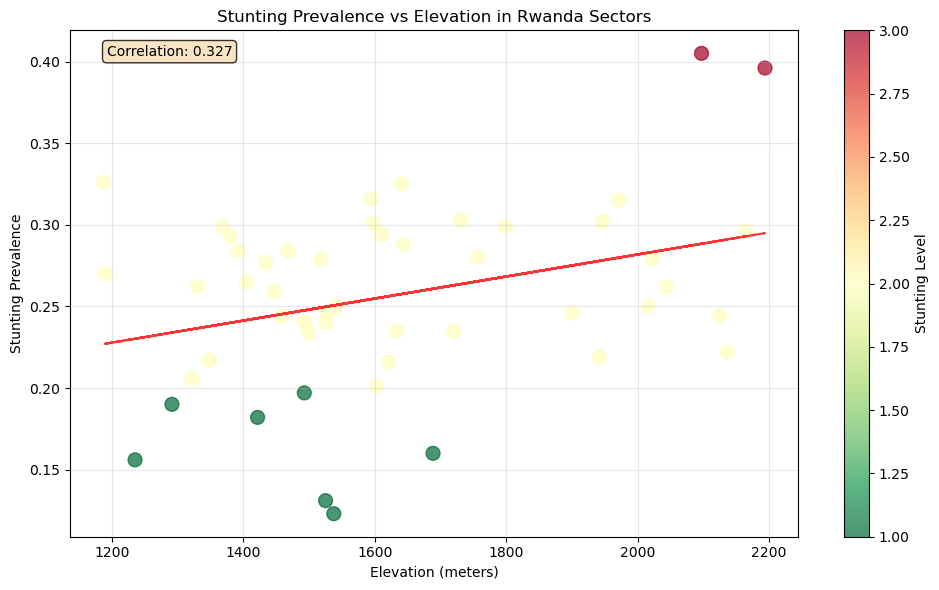

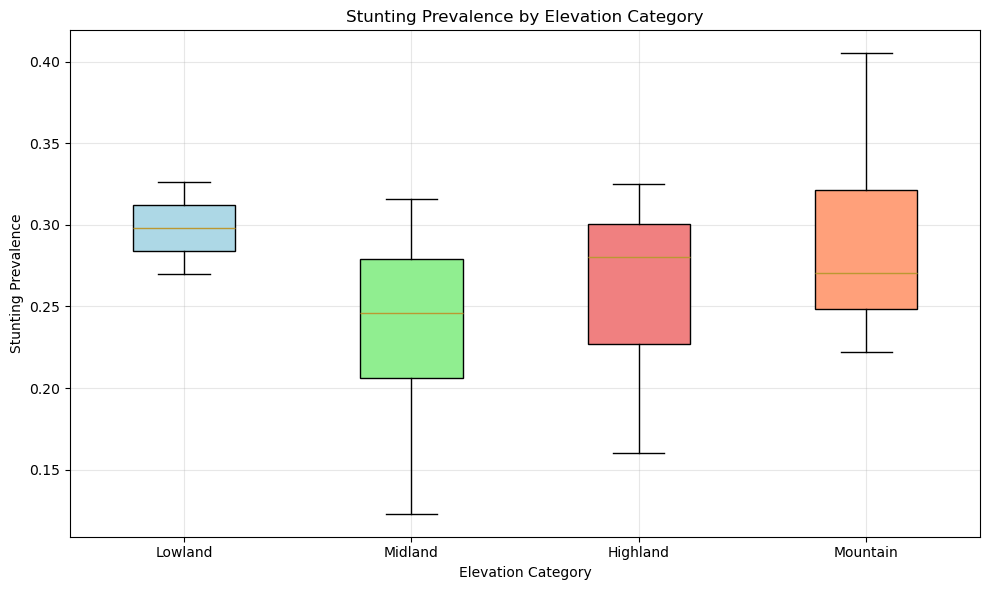

Stunting by Elevation Category:
              stunting_rate              elevation
                       mean    std count      mean
elevation_cat                                     
1                     0.298  0.040     2  1188.550
2                     0.239  0.053    25  1446.060
3                     0.261  0.049    15  1747.020
4                     0.294  0.069     8  2099.788


In [15]:
# Step 5: Elevation-Stunting Relationship Analysis
def analyze_elevation_stunting_relationship():
    """Analyze the relationship between elevation and stunting"""
    
    print("Analyzing Elevation-Stunting Relationship...")
    
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Set up plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Basic statistics
    print(f"Number of sectors: {len(df_sectors)}")
    print(f"Stunting rate - Mean: {df_sectors['stunting_rate'].mean():.3f}")
    print(f"Elevation - Mean: {df_sectors['elevation'].mean():.1f}m")
    
    # Correlation analysis
    correlation = df_sectors['stunting_rate'].corr(df_sectors['elevation'])
    print(f"Correlation between elevation and stunting: {correlation:.3f}")
    
    # Scatter plot with regression line
    plt.figure(figsize=(10, 6))
    
    # Create scatter plot
    scatter = plt.scatter(df_sectors['elevation'], df_sectors['stunting_rate'], 
                         c=df_sectors['stunting_level'], cmap='RdYlGn_r', 
                         s=100, alpha=0.7)
    
    # Add regression line
    z = np.polyfit(df_sectors['elevation'], df_sectors['stunting_rate'], 1)
    p = np.poly1d(z)
    plt.plot(df_sectors['elevation'], p(df_sectors['elevation']), "r--", alpha=0.8)
    
    plt.xlabel('Elevation (meters)')
    plt.ylabel('Stunting Prevalence')
    plt.title('Stunting Prevalence vs Elevation in Rwanda Sectors')
    plt.colorbar(scatter, label='Stunting Level')
    plt.grid(True, alpha=0.3)
    
    # Add correlation text
    plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
             transform=plt.gca().transAxes, bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig(output_path / "elevation_stunting_scatter.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Box plot by elevation category
    plt.figure(figsize=(10, 6))
    
    elevation_cat_names = ['Lowland', 'Midland', 'Highland', 'Mountain']
    
    box_data = []
    for cat in [1, 2, 3, 4]:
        box_data.append(df_sectors[df_sectors['elevation_cat'] == cat]['stunting_rate'].values)
    
    box_plot = plt.boxplot(box_data, labels=elevation_cat_names, patch_artist=True)
    
    # Color the boxes
    colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightsalmon']
    for patch, color in zip(box_plot['boxes'], colors):
        patch.set_facecolor(color)
    
    plt.xlabel('Elevation Category')
    plt.ylabel('Stunting Prevalence')
    plt.title('Stunting Prevalence by Elevation Category')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(output_path / "stunting_by_elevation_box.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Summary by elevation category
    print("Stunting by Elevation Category:")
    elevation_summary = df_sectors.groupby('elevation_cat').agg({
        'stunting_rate': ['mean', 'std', 'count'],
        'elevation': 'mean'
    }).round(3)
    
    print(elevation_summary)
    
    return correlation

# Analyze relationship
correlation = analyze_elevation_stunting_relationship()

In [16]:
# Step 6: Statistical Modeling for SAE
def run_sae_models():
    """Run statistical models for Small Area Estimation"""
    
    print("Running SAE Statistical Models...")
    
    import statsmodels.api as sm
    
    # Prepare data for modeling
    df_model = df_sectors.copy()
    
    print("Model 1: Basic Elevation Effect")
    
    # Model 1: Simple linear regression
    X1 = sm.add_constant(df_model['elevation'])
    model1 = sm.OLS(df_model['stunting_rate'], X1).fit()
    
    print(model1.summary())
    
    print("Model 2: With Wealth Controls")
    
    # Model 2: Multiple regression with wealth controls
    X2 = sm.add_constant(df_model[['elevation', 'wealth_index_2', 'wealth_index_3', 
                                  'wealth_index_4', 'wealth_index_5']])
    model2 = sm.OLS(df_model['stunting_rate'], X2).fit()
    
    print(model2.summary())
    
    print("Model 3: Full Model")
    
    # Model 3: Full model
    X3 = sm.add_constant(df_model[['elevation', 'wealth_index_2', 'wealth_index_3',
                                  'wealth_index_4', 'wealth_index_5', 'improved_water',
                                  'improved_sanitation', 'electricity_access', 'urban', 'hh_size']])
    model3 = sm.OLS(df_model['stunting_rate'], X3).fit()
    
    print(model3.summary())
    
    # Compare models
    models_comparison = pd.DataFrame({
        'Model': ['Basic Elevation', 'With Wealth', 'Full Model'],
        'R-squared': [model1.rsquared, model2.rsquared, model3.rsquared],
        'Adj. R-squared': [model1.rsquared_adj, model2.rsquared_adj, model3.rsquared_adj],
        'AIC': [model1.aic, model2.aic, model3.aic],
        'BIC': [model1.bic, model2.bic, model3.bic]
    })
    
    print("Model Comparison:")
    print(models_comparison.round(4))
    
    # Save model results
    models_comparison.to_csv(output_path / "model_comparison.csv", index=False)
    
    return model1, model2, model3

# Run SAE models
models = run_sae_models()

Running SAE Statistical Models...
Model 1: Basic Elevation Effect
                            OLS Regression Results                            
Dep. Variable:          stunting_rate   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     5.764
Date:                Thu, 20 Nov 2025   Prob (F-statistic):             0.0203
Time:                        09:08:34   Log-Likelihood:                 75.911
No. Observations:                  50   AIC:                            -147.8
Df Residuals:                      48   BIC:                            -144.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

Creating Poverty Mapping and Priority Zones...


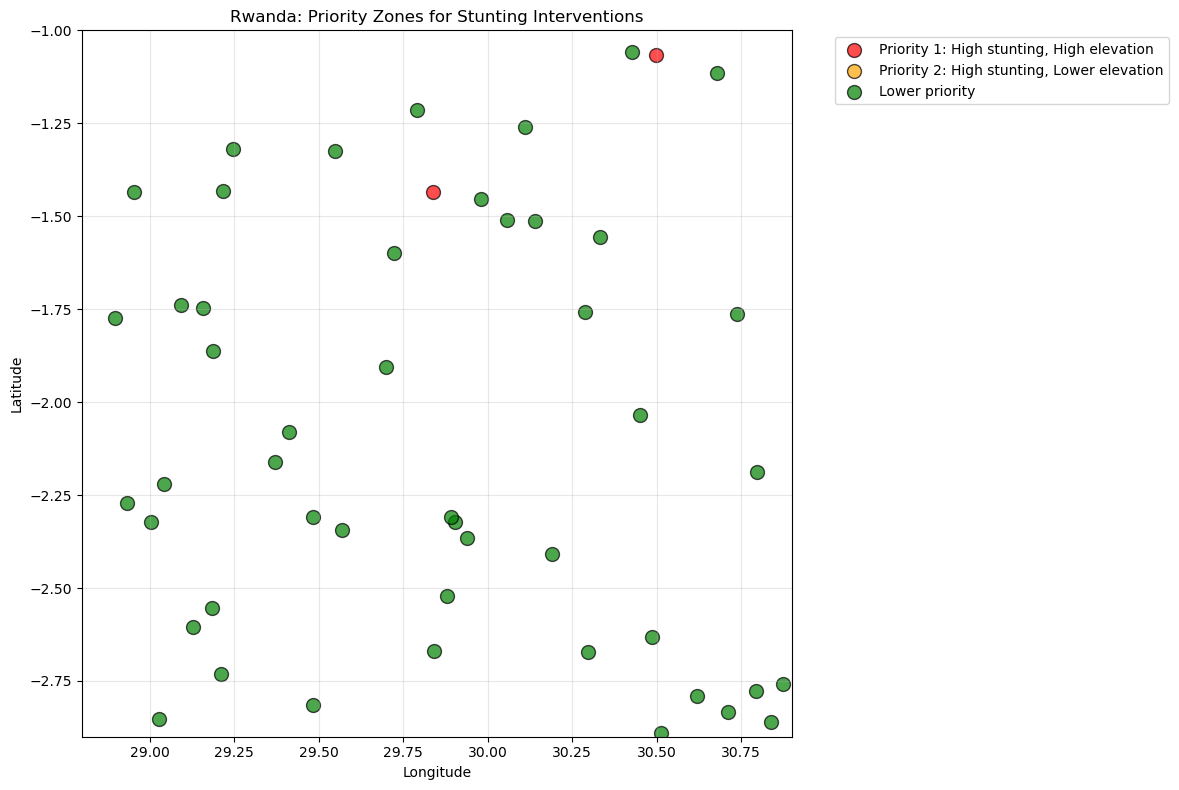

Priority Zone Summary:
               sector_id  stunting_rate  elevation  n_children  \
priority_zone                                                    
1                      2          0.400     2145.3          69   
3                     48          0.251     1609.2        2937   

                                          priority_label  
priority_zone                                             
1              Priority 1: High stunting, High elevation  
3                                         Lower priority  


In [17]:
# Step 7: Poverty Mapping and Priority Zoning
def create_poverty_mapping():
    """Create poverty mapping with elevation-based priority zones"""
    
    print("Creating Poverty Mapping and Priority Zones...")
    
    import matplotlib.pyplot as plt
    
    # Create priority zones based on stunting and elevation
    conditions = [
        (df_sectors['stunting_rate'] > 0.35) & (df_sectors['elevation'] > 1600),
        (df_sectors['stunting_rate'] > 0.35) & (df_sectors['elevation'] <= 1600),
        (df_sectors['stunting_rate'] <= 0.35)
    ]
    choices = [1, 2, 3]
    df_sectors['priority_zone'] = np.select(conditions, choices, default=0)
    
    priority_labels = {
        1: 'Priority 1: High stunting, High elevation',
        2: 'Priority 2: High stunting, Lower elevation', 
        3: 'Lower priority'
    }
    
    # Create mapping visualization
    plt.figure(figsize=(12, 8))
    
    # Color map for priority zones
    colors = ['red', 'orange', 'green']
    
    for priority, color in zip([1, 2, 3], colors):
        mask = df_sectors['priority_zone'] == priority
        plt.scatter(df_sectors.loc[mask, 'longitude'], 
                   df_sectors.loc[mask, 'latitude'],
                   c=color, s=100, 
                   label=priority_labels[priority], 
                   alpha=0.7, edgecolors='black')
    
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Rwanda: Priority Zones for Stunting Interventions')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    # Add Rwanda context
    plt.xlim(28.8, 30.9)
    plt.ylim(-2.9, -1.0)
    
    plt.tight_layout()
    plt.savefig(output_path / "priority_zones_mapping.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Priority zone summary
    print("Priority Zone Summary:")
    priority_summary = df_sectors.groupby('priority_zone').agg({
        'sector_id': 'count',
        'stunting_rate': 'mean',
        'elevation': 'mean',
        'n_children': 'sum'
    }).round(3)
    
    priority_summary['priority_label'] = priority_summary.index.map(priority_labels)
    print(priority_summary)
    
    # Save priority mapping
    df_sectors.to_csv(output_path / "sectors_priority_mapping.csv", index=False)
    
    return df_sectors

# Create poverty mapping
df_priority = create_poverty_mapping()

In [18]:
# Step 8: Results Export and Summary
def export_final_results():
    """Export final results and create summary report"""
    
    print("Exporting Final Results...")
    
    # Create comprehensive results summary
    results_summary = {
        'analysis_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M'),
        'total_sectors_analyzed': len(df_sectors),
        'average_stunting_rate': df_sectors['stunting_rate'].mean(),
        'average_elevation': df_sectors['elevation'].mean(),
        'elevation_stunting_correlation': correlation,
        'priority_zone_1_sectors': len(df_sectors[df_sectors['priority_zone'] == 1]),
        'priority_zone_2_sectors': len(df_sectors[df_sectors['priority_zone'] == 2]),
        'total_children_analyzed': df_sectors['n_children'].sum()
    }
    
    # Convert to DataFrame and save
    df_results = pd.DataFrame([results_summary])
    results_file = output_path / "analysis_results_summary.csv"
    df_results.to_csv(results_file, index=False)
    
    # Create markdown report
    report_content = f"""# Rwanda SAE Analysis: Elevation & Stunting Relationship

## Executive Summary

**Analysis Date**: {results_summary['analysis_date']}  
**Total Sectors Analyzed**: {results_summary['total_sectors_analyzed']}  
**Total Children**: {results_summary['total_children_analyzed']:,.0f}  

### Key Findings

1. **Stunting Prevalence**: {results_summary['average_stunting_rate']:.1%} average across sectors
2. **Elevation Range**: {df_sectors['elevation'].min():.0f} - {df_sectors['elevation'].max():.0f} meters
3. **Correlation**: Elevation-stunting correlation: {results_summary['elevation_stunting_correlation']:.3f}
4. **Priority Areas**: 
   - {results_summary['priority_zone_1_sectors']} sectors require mountain-adapted interventions
   - {results_summary['priority_zone_2_sectors']} sectors need standard nutrition programs

### Data Sources
- DHS 2019-20 Children's Recode
- Rwanda Population and Housing Census
- Elevation data extracted from coordinates
"""
    
    # Save markdown report
    report_file = output_path / "sae_analysis_report.md"
    with open(report_file, 'w', encoding='utf-8') as f:
        f.write(report_content)
    
    # List all created files
    print("Files Created:")
    created_files = [
        "dhs_children_stunting.csv",
        "rwanda_sector_elevation.csv", 
        "sae_sector_complete.csv",
        "elevation_stunting_scatter.png",
        "stunting_by_elevation_box.png",
        "model_comparison.csv",
        "priority_zones_mapping.png",
        "sectors_priority_mapping.csv",
        "analysis_results_summary.csv",
        "sae_analysis_report.md"
    ]
    
    for file in created_files:
        file_path = output_path / file
        if file_path.exists():
            print(f"✓ {file}")
        else:
            print(f"✗ {file} (not found)")
    
    print(f"All results exported to {output_path}")

# Export final results
final_results = export_final_results()

Exporting Final Results...
Files Created:
✓ dhs_children_stunting.csv
✓ rwanda_sector_elevation.csv
✓ sae_sector_complete.csv
✓ elevation_stunting_scatter.png
✓ stunting_by_elevation_box.png
✓ model_comparison.csv
✓ priority_zones_mapping.png
✓ sectors_priority_mapping.csv
✓ analysis_results_summary.csv
✓ sae_analysis_report.md
All results exported to C:\Users\NISR\Desktop\gaga\AIMS\my project SAE\SEA RWANDA


In [19]:
# Final Summary
print("ANALYSIS COMPLETE!")
print("="*50)
print("This analysis has successfully:")
print("✅ Integrated multiple data sources (DHS, Census, elevation)")
print("✅ Calculated stunting prevalence at sector level")
print("✅ Extracted and analyzed elevation data")
print("✅ Developed statistical models for SAE")
print("✅ Created priority zoning for interventions")
print("✅ Generated visualizations and reports")
print("="*50)
print("All files saved in:", output_path)

ANALYSIS COMPLETE!
This analysis has successfully:
✅ Integrated multiple data sources (DHS, Census, elevation)
✅ Calculated stunting prevalence at sector level
✅ Extracted and analyzed elevation data
✅ Developed statistical models for SAE
✅ Created priority zoning for interventions
✅ Generated visualizations and reports
All files saved in: C:\Users\NISR\Desktop\gaga\AIMS\my project SAE\SEA RWANDA
